In [1]:
import os
os.chdir('/home/kruu/git_folder/eye_tracking/')
# os.chdir('C:/Users/kruu/git_folder/eye_tracking/')

import pandas as pd
import numpy as np
import joblib

from utils.data_processing import EyeTrackingProcessor

import matplotlib.pyplot as plt

****
# General Performance
****

In [2]:
loaded_grid_search = joblib.load("/home/kruu/git_folder/eye_tracking/trainings/logs/xgboost_classifier/full_grid_search.pkl")

In [3]:
loaded_grid_search.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_colsample_bytree', 'param_gamma', 'param_learning_rate', 'param_max_depth', 'param_n_estimators', 'param_subsample', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [4]:
mean_scores = loaded_grid_search.cv_results_["mean_test_score"]
min_score = mean_scores.min()
max_score = mean_scores.max()
avg_score = mean_scores.mean()

print(f"Grid Search Score Summary:")
print(f"Lowest Accuracy: {min_score:.4f}")
print(f"Highest Accuracy (Best Score): {max_score:.4f}")
print(f"Average Accuracy across all configs: {avg_score:.4f}")

Grid Search Score Summary:
Lowest Accuracy: 0.2901
Highest Accuracy (Best Score): 0.3148
Average Accuracy across all configs: 0.3040


****
# Results analysis
****

In [ ]:
from utils.helper import load_and_process

root_dir = "/store/kruu/eye_tracking/training_data"
features = ['Recording timestamp [ms]', 'Gaze point X [DACS px]', 'Gaze point Y [DACS px]', 'Mouse position X', 'Mouse position Y', 'Event']
interpolate_cols = ['Gaze point X [DACS px]', 'Gaze point Y [DACS px]', 'Mouse position X', 'Mouse position Y', "Blink"]
fill_columns = ['Gaze point X [DACS px]', 'Gaze point Y [DACS px]', 'Mouse position X', 'Mouse position Y']

chunks, blinks, atco_task_map  = load_and_process(root_dir=root_dir, 
                                                    columns=features, 
                                                    interpolate_cols=interpolate_cols, 
                                                    fill_cols=fill_columns, 
                                                    time_resampling=True, 
                                                    fixed_window_ms=10000, # Size of the chunk window. None if chunk per task
                                                    window_step_ms=2000, # Time step from one window to another. None is no overlap
                                                    min_task_presence=0.5 # Min proportion of task presence for assigning a label
                                                    )

In [6]:
import json
from pathlib import Path

metadata_path = "trainings/logs/jcafnet_classifier/silvery-morning-8/jcafnet_metadata.json"

if Path(metadata_path).exists():
    print("Loading JCAFNet metadata for consistent train test split... ")
    with open(metadata_path) as f:
        metadata = json.load(f)
        
train_ids = metadata["train_ids"]
val_ids = metadata["val_ids"]
test_ids = metadata["test_ids"]

Loading JCAFNet metadata for consistent train test split... 


In [11]:
import pandas as pd
from utils.data_processing import GazeMetricsProcessor, MouseMetricsProcessor
from utils.helper import drop_chunks_with_all_zero_features
from trainings._02_xgboost_training import extract_tsfresh_features_from_chunks

gaze_metrics = []
mouse_metrics = []

for task_id, chunk in chunks.items():
        for col in fill_columns:
            chunks[task_id][col] = chunks[task_id][col].ffill().bfill()

for id, chunk_df in chunks.items():
    
    # Extracting gaze metrics
    gaze_processor = GazeMetricsProcessor(chunk_df, timestamp_unit="ms")
    gaze_compute = gaze_processor.compute_all_metrics()
    gaze_compute.update({"id": id})
    gaze_compute.update({"participant_id": chunk_df["Participant name"].iloc[0]})
    gaze_compute.update({"Task_id": chunk_df["Task_id"].iloc[0]})
    gaze_metrics.append(gaze_compute)
    
    # Extracting mouse metrics
    mouse_processor = MouseMetricsProcessor(chunk_df, timestamp_unit="ms")
    mouse_compute = mouse_processor.compute_all_metrics()
    mouse_compute.update({"id": id})
    mouse_compute.update({"participant_id": chunk_df["Participant name"].iloc[0]})
    mouse_compute.update({"Task_id": chunk_df["Task_id"].iloc[0]})
    mouse_metrics.append(mouse_compute)
    
gaze_metrics_df = pd.DataFrame(gaze_metrics)
mouse_metrics_df = pd.DataFrame(mouse_metrics)

columns_to_extract = ['Gaze point X [DACS px]', 'Gaze point Y [DACS px]', 'Mouse position X', 'Mouse position Y']
cleaned_chunks_xgb = drop_chunks_with_all_zero_features(chunks, feature_cols=columns_to_extract, threshold=0.5)

tsfresh_data = extract_tsfresh_features_from_chunks(
        cleaned_chunks_xgb, 
        columns_to_extract, 
        pval_threshold=0.05, 
        n_jobs=100)

cols_to_drop = [
    "Seconds per raw time unit",
    "Timestamp column",
    "Gaze X column", "Gaze Y column",
    "Mouse X column", "Mouse Y column",
]

gaze = gaze_metrics_df.drop(columns=cols_to_drop, errors="ignore")
mouse = mouse_metrics_df.drop(columns=cols_to_drop, errors="ignore")
merge_keys = ["id", "participant_id", "Task_id"]
merged = gaze.merge(mouse, on=merge_keys, how="inner", suffixes=("_gaze", "_mouse"))
final_merged = merged.merge(tsfresh_data, on="id", how="inner")

Dropped 9847 chunks (threshold=0.5): ['001_1_-1_0', '001_1_-1_6', '001_1_-1_7', '001_1_-1_8', '001_1_-1_9', '001_1_-1_10', '001_1_-1_11', '001_1_-1_12', '001_1_-1_13', '001_1_-1_21'] ...
Extracting TSFresh features...


Feature Extraction: 100%|██████████| 500/500 [01:58<00:00,  4.21it/s]


In [28]:
final_merged.Task_id.value_counts()

Task_id
-1     61602
 12     8164
 1      5418
 13     3733
 5      2287
 2      2099
 0      2073
 11     1830
 8      1627
 10     1047
 6       493
 9       322
 3       276
 4       164
 7        91
Name: count, dtype: int64

In [33]:
from sklearn.model_selection import GroupShuffleSplit

def split_by_participant(df: pd.DataFrame,
                         group_col="participant_id",
                         test_size=0.2,
                         random_state=42):
    
    # Split test / train by participant (no val as we use cv later)
    gss = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    train_idx, test_idx = next(gss.split(df, groups=df[group_col]))
    df_train = df.iloc[train_idx].copy()
    df_test     = df.iloc[test_idx].copy()

    # Optional: return the participant IDs per split
    parts = {
        "train_ids": sorted(df_train[group_col].unique().tolist()),
        "test_ids":  sorted(df_test[group_col].unique().tolist()),
    }
    return df_train, df_test, parts

train_df, test_df, parts = split_by_participant(final_merged, group_col="participant_id",
                                                        test_size=0.2, random_state=42)


In [38]:
train_df.Task_id.value_counts()

Task_id
-1     48042
 12     6058
 1      3804
 13     2734
 2      1725
 5      1653
 0      1588
 11     1370
 8      1338
 10      819
 6       382
 3       235
 9       229
 4       104
 7        91
Name: count, dtype: int64

In [ ]:
# WARNING: Some participant didn't perform task 7
test_df.Task_id.value_counts()

Task_id
-1     13560
 12     2106
 1      1614
 13      999
 5       634
 0       485
 11      460
 2       374
 8       289
 10      228
 6       111
 9        93
 4        60
 3        41
Name: count, dtype: int64

In [47]:
# Imbalance of trianing
y = train_df.Task_id.values + 1
counts = pd.Series(y).value_counts()
class_w = (np.sqrt(counts.median()) / np.sqrt(counts)).to_dict()
sw = np.array([class_w[yi] for yi in y])

In [48]:
class_w

{0: 0.1688689271045532,
 13: 0.47554941206421997,
 2: 0.6001226653439414,
 14: 0.7078822595199621,
 3: 0.8911806206099439,
 6: 0.9103824077011063,
 1: 0.9288274344692182,
 12: 1.0,
 9: 1.0118874902747779,
 11: 1.2933567461345197,
 7: 1.8937759726416885,
 4: 2.414495233799925,
 10: 2.445921656777196,
 5: 3.629473367181102,
 8: 3.8800702384035595}

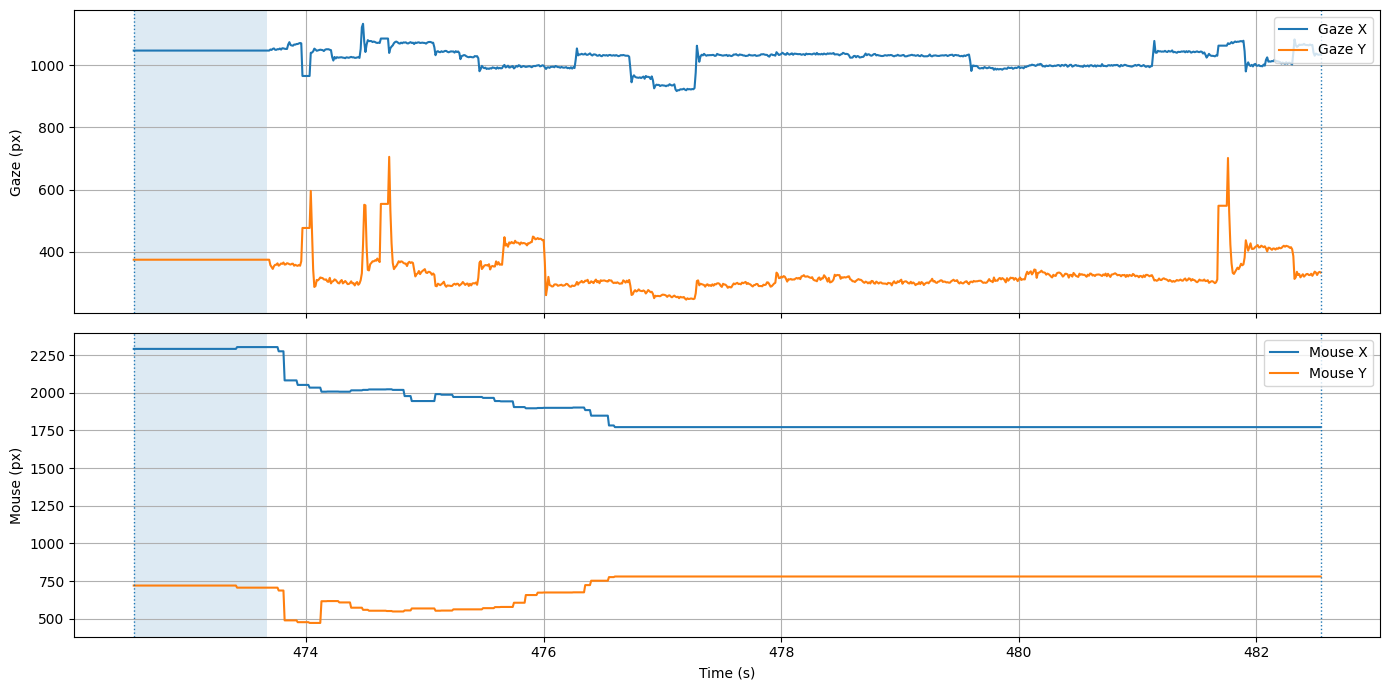

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_gaze_mouse(df):
    # Ensure proper order and seconds on x-axis
    df = df.sort_values("Recording timestamp [ms]").reset_index(drop=True).copy()
    t = df["Recording timestamp [ms]"] / 1000.0

    fig, axes = plt.subplots(2, 1, figsize=(14, 7), sharex=True)

    # --- Gaze subplot ---
    axes[0].plot(t, df["Gaze point X [DACS px]"], label="Gaze X")
    axes[0].plot(t, df["Gaze point Y [DACS px]"], label="Gaze Y")
    axes[0].set_ylabel("Gaze (px)")
    axes[0].grid(True)
    axes[0].legend(loc="upper right")
    axes[0].axvline(t.iloc[0], linestyle=":", linewidth=1)
    axes[0].axvline(t.iloc[-1], linestyle=":", linewidth=1)

    # --- Mouse subplot ---
    axes[1].plot(t, df["Mouse position X"], label="Mouse X")
    axes[1].plot(t, df["Mouse position Y"], label="Mouse Y")
    axes[1].set_ylabel("Mouse (px)")
    axes[1].set_xlabel("Time (s)")
    axes[1].grid(True)
    axes[1].legend(loc="upper right")
    axes[1].axvline(t.iloc[0], linestyle=":", linewidth=1)
    axes[1].axvline(t.iloc[-1], linestyle=":", linewidth=1)

    # --- Optional: shade blink intervals (if present) ---
    if "Blink" in df.columns:
        blink = df["Blink"].astype(bool).values
        # find contiguous blink runs
        run_id = (pd.Series(blink).ne(pd.Series(blink).shift(fill_value=False))).cumsum().values
        for rid in np.unique(run_id[blink]):
            idx = np.where(run_id == rid)[0]
            axes[0].axvspan(t.iloc[idx[0]], t.iloc[idx[-1]], alpha=0.15)
            axes[1].axvspan(t.iloc[idx[0]], t.iloc[idx[-1]], alpha=0.15)

    plt.tight_layout()
    plt.show()
    
plot_gaze_mouse(chunks["001_1_0_5"])

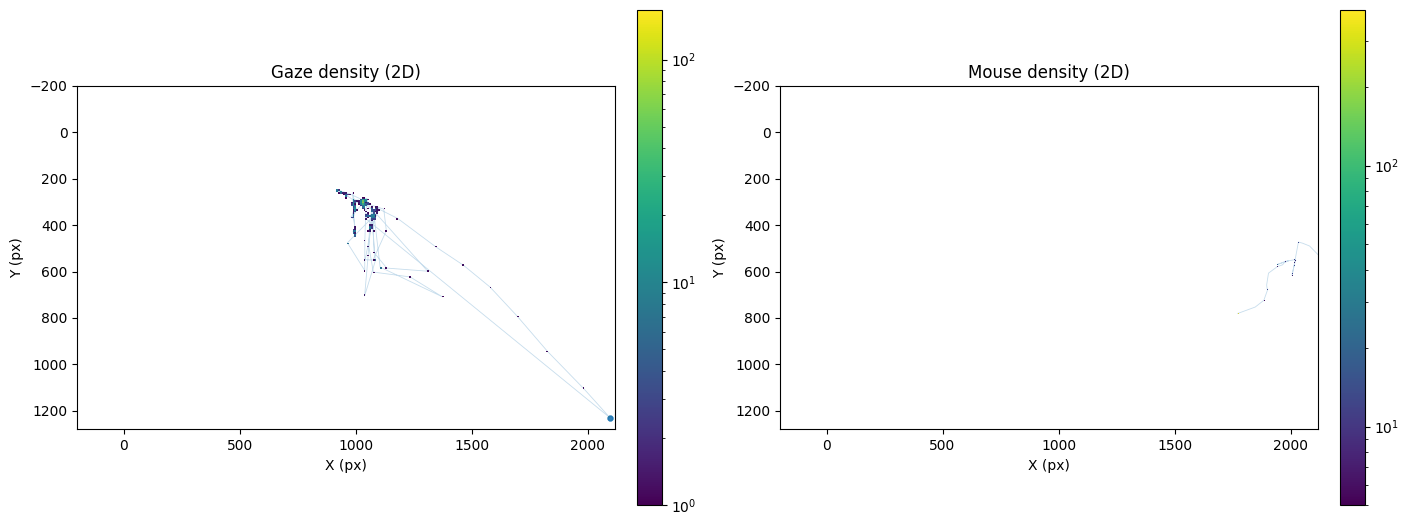

In [33]:
from matplotlib.colors import LogNorm  # nicer dynamic range

def plot_gaze_mouse_heatmaps(df,
                             gaze_x="Gaze point X [DACS px]",
                             gaze_y="Gaze point Y [DACS px]",
                             mouse_x="Mouse position X",
                             mouse_y="Mouse position Y",
                             invert_y=True,  # pixel coords usually have y downwards
                             bins=150):
    # Clean numeric
    gxs = pd.to_numeric(df[gaze_x], errors="coerce")
    gys = pd.to_numeric(df[gaze_y], errors="coerce")
    mxs = pd.to_numeric(df[mouse_x], errors="coerce")
    mys = pd.to_numeric(df[mouse_y], errors="coerce")

    fig, axes = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)

    # --- Gaze heatmap ---
    h1 = axes[0].hist2d(gxs, gys, bins=bins, norm=LogNorm())
    axes[0].set_title("Gaze density (2D)")
    axes[0].set_xlabel("X (px)")
    axes[0].set_ylabel("Y (px)")
    axes[0].set_aspect("equal", adjustable="box")
    axes[0].set_xlim(-200, 2120)
    axes[0].set_ylim(-200, 1280)
    if invert_y: axes[0].invert_yaxis()
    fig.colorbar(h1[3], ax=axes[0], fraction=0.046, pad=0.04)

    # Optional: overlay gaze path lightly
    axes[0].plot(gxs.values, gys.values, linewidth=0.6, alpha=0.25)

    # --- Mouse heatmap ---
    h2 = axes[1].hist2d(mxs, mys, bins=bins, norm=LogNorm())
    axes[1].set_title("Mouse density (2D)")
    axes[1].set_xlabel("X (px)")
    axes[1].set_ylabel("Y (px)")
    axes[1].set_aspect("equal", adjustable="box")
    axes[1].set_xlim(-200, 2120)
    axes[1].set_ylim(-200, 1280)
    if invert_y: axes[1].invert_yaxis()
    fig.colorbar(h2[3], ax=axes[1], fraction=0.046, pad=0.04)

    # Optional: overlay mouse path lightly
    axes[1].plot(mxs.values, mys.values, linewidth=0.6, alpha=0.25)

    # Optional: shade blink segments on both plots
    if "Blink" in df.columns:
        blink = df["Blink"].astype(bool).to_numpy()
        # find contiguous blink runs
        run_id = (pd.Series(blink).ne(pd.Series(blink).shift(fill_value=False))).cumsum().to_numpy()
        for rid in np.unique(run_id[blink]):
            idx = np.where(run_id == rid)[0]
            # mark start/end points
            for ax, xs, ys in [(axes[0], gxs, gys), (axes[1], mxs, mys)]:
                ax.scatter(xs.iloc[idx[[0, -1]]], ys.iloc[idx[[0, -1]]],
                           s=12, alpha=0.7)

    plt.show()

plot_gaze_mouse_heatmaps(chunks["001_1_0_4"])

****
# Confuction Matrix
****

In [16]:
data_path = '/store/kruu/eye_tracking/splits'
train_df = pd.read_parquet(f"{data_path}/train/train_xgboost.parquet")
test_df = pd.read_parquet(f"{data_path}/test/test_xgboost.parquet")
val_df = pd.read_parquet(f"{data_path}/val/val_xgboost.parquet")

In [26]:
import importlib
import models.ensemble_inference as models
importlib.reload(models)
from models.ensemble_inference import load_xgboost_model, predict_xgboost

xgb_model_path = "trainings/logs/xgboost_classifier/best_model.pkl"
xg_boost = load_xgboost_model(xgb_model_path)

preds_xgboost = predict_xgboost(
    test_df=test_df,
    model_path=xgb_model_path,
    selected_features_path="trainings/logs/xgboost_classifier/features.pkl",
)

ValueError: feature_names mismatch: ['Fixation_Count', 'Total_Fixation_Duration_(s)', 'Avg_Fixation_Duration_(s)', 'Saccade_Count', 'Avg_Saccade_Amplitude_(px)', 'Avg_Saccade_Velocity_(px/s)', 'Avg_Gaze_Velocity_(px/s)', 'Avg_Gaze_Acceleration_(px/s²)', 'Blink_Rate_(blinks/s)', 'Gaze_Dispersion_(area_px²)', 'Avg_Mouse_Velocity_(px/s)', 'Avg_Mouse_Acceleration_(px/s²)', 'Movement_Frequency_(movements/s)', 'Total_Idle_Time_(s)', 'Click_Count', 'Keyboard_Count', 'Path_Direction_Changes', 'Total_Distance_Traveled_(px)', 'Number_of_Stops', 'Movement_Bursts', 'Stillness_Periods', 'Gaze_point_Y__DACS_px___variance', 'Gaze_point_Y__DACS_px___standard_deviation', 'Gaze_point_Y__DACS_px___absolute_maximum', 'Gaze_point_Y__DACS_px___maximum', 'Gaze_point_X__DACS_px___length', 'Mouse_position_X__length', 'Gaze_point_Y__DACS_px___length', 'Mouse_position_Y__length', 'Gaze_point_Y__DACS_px___root_mean_square', 'Mouse_position_Y__root_mean_square', 'Mouse_position_Y__absolute_maximum', 'Mouse_position_Y__maximum', 'Mouse_position_Y__sum_values', 'Mouse_position_Y__mean', 'Mouse_position_Y__median', 'Gaze_point_X__DACS_px___absolute_maximum', 'Gaze_point_X__DACS_px___maximum', 'Gaze_point_X__DACS_px___standard_deviation', 'Gaze_point_X__DACS_px___variance', 'Gaze_point_Y__DACS_px___sum_values', 'Gaze_point_Y__DACS_px___mean', 'Gaze_point_X__DACS_px___root_mean_square', 'Gaze_point_X__DACS_px___sum_values', 'Gaze_point_X__DACS_px___mean', 'Gaze_point_X__DACS_px___median', 'Gaze_point_Y__DACS_px___median', 'Mouse_position_X__minimum', 'Mouse_position_Y__minimum', 'Mouse_position_X__variance', 'Mouse_position_X__standard_deviation', 'Mouse_position_Y__standard_deviation', 'Mouse_position_Y__variance', 'Gaze_point_Y__DACS_px___minimum', 'Mouse_position_X__mean', 'Mouse_position_X__sum_values', 'Mouse_position_X__root_mean_square', 'Mouse_position_X__median', 'Gaze_point_X__DACS_px___minimum', 'Mouse_position_X__absolute_maximum', 'Mouse_position_X__maximum'] ['Fixation Count', 'Total Fixation Duration (s)', 'Avg Fixation Duration (s)', 'Saccade Count', 'Avg Saccade Amplitude (px)', 'Avg Saccade Velocity (px/s)', 'Avg Gaze Velocity (px/s)', 'Avg Gaze Acceleration (px/s²)', 'Blink Rate (blinks/s)', 'Gaze Dispersion (area_px²)', 'Avg Mouse Velocity (px/s)', 'Avg Mouse Acceleration (px/s²)', 'Movement Frequency (movements/s)', 'Total Idle Time (s)', 'Click Count', 'Keyboard Count', 'Path Direction Changes', 'Total Distance Traveled (px)', 'Number of Stops', 'Movement Bursts', 'Stillness Periods', 'Gaze point Y [DACS px]__variance', 'Gaze point Y [DACS px]__standard_deviation', 'Gaze point Y [DACS px]__absolute_maximum', 'Gaze point Y [DACS px]__maximum', 'Gaze point X [DACS px]__length', 'Mouse position X__length', 'Gaze point Y [DACS px]__length', 'Mouse position Y__length', 'Gaze point Y [DACS px]__root_mean_square', 'Mouse position Y__root_mean_square', 'Mouse position Y__absolute_maximum', 'Mouse position Y__maximum', 'Mouse position Y__sum_values', 'Mouse position Y__mean', 'Mouse position Y__median', 'Gaze point X [DACS px]__absolute_maximum', 'Gaze point X [DACS px]__maximum', 'Gaze point X [DACS px]__standard_deviation', 'Gaze point X [DACS px]__variance', 'Gaze point Y [DACS px]__sum_values', 'Gaze point Y [DACS px]__mean', 'Gaze point X [DACS px]__root_mean_square', 'Gaze point X [DACS px]__sum_values', 'Gaze point X [DACS px]__mean', 'Gaze point X [DACS px]__median', 'Gaze point Y [DACS px]__median', 'Mouse position X__minimum', 'Mouse position Y__minimum', 'Mouse position X__variance', 'Mouse position X__standard_deviation', 'Mouse position Y__standard_deviation', 'Mouse position Y__variance', 'Gaze point Y [DACS px]__minimum', 'Mouse position X__mean', 'Mouse position X__sum_values', 'Mouse position X__root_mean_square', 'Mouse position X__median', 'Gaze point X [DACS px]__minimum', 'Mouse position X__absolute_maximum', 'Mouse position X__maximum']
expected Mouse_position_X__maximum, Total_Idle_Time_(s), Gaze_point_Y__DACS_px___standard_deviation, Movement_Bursts, Gaze_point_Y__DACS_px___root_mean_square, Gaze_point_X__DACS_px___mean, Gaze_point_X__DACS_px___standard_deviation, Mouse_position_Y__absolute_maximum, Gaze_point_X__DACS_px___variance, Total_Distance_Traveled_(px), Gaze_point_Y__DACS_px___minimum, Gaze_Dispersion_(area_px²), Mouse_position_X__length, Movement_Frequency_(movements/s), Keyboard_Count, Mouse_position_Y__root_mean_square, Avg_Fixation_Duration_(s), Gaze_point_X__DACS_px___sum_values, Mouse_position_Y__standard_deviation, Mouse_position_Y__median, Mouse_position_X__mean, Avg_Saccade_Velocity_(px/s), Avg_Mouse_Velocity_(px/s), Path_Direction_Changes, Gaze_point_X__DACS_px___length, Mouse_position_X__standard_deviation, Gaze_point_X__DACS_px___maximum, Mouse_position_Y__minimum, Mouse_position_X__root_mean_square, Gaze_point_Y__DACS_px___length, Mouse_position_Y__sum_values, Saccade_Count, Mouse_position_Y__maximum, Mouse_position_Y__variance, Gaze_point_Y__DACS_px___sum_values, Gaze_point_Y__DACS_px___variance, Gaze_point_Y__DACS_px___absolute_maximum, Mouse_position_X__minimum, Gaze_point_X__DACS_px___minimum, Fixation_Count, Mouse_position_X__median, Gaze_point_Y__DACS_px___maximum, Click_Count, Blink_Rate_(blinks/s), Mouse_position_X__absolute_maximum, Mouse_position_Y__mean, Avg_Mouse_Acceleration_(px/s²), Total_Fixation_Duration_(s), Gaze_point_X__DACS_px___root_mean_square, Mouse_position_Y__length, Stillness_Periods, Mouse_position_X__sum_values, Gaze_point_X__DACS_px___absolute_maximum, Gaze_point_Y__DACS_px___mean, Gaze_point_X__DACS_px___median, Gaze_point_Y__DACS_px___median, Number_of_Stops, Avg_Gaze_Velocity_(px/s), Avg_Saccade_Amplitude_(px), Mouse_position_X__variance, Avg_Gaze_Acceleration_(px/s²) in input data
training data did not have the following fields: Saccade Count, Mouse position X__absolute_maximum, Mouse position Y__absolute_maximum, Gaze point Y [DACS px]__sum_values, Gaze point X [DACS px]__median, Number of Stops, Gaze point Y [DACS px]__length, Gaze point X [DACS px]__absolute_maximum, Keyboard Count, Mouse position X__variance, Mouse position X__maximum, Mouse position X__median, Movement Frequency (movements/s), Gaze point X [DACS px]__length, Mouse position Y__sum_values, Stillness Periods, Gaze point Y [DACS px]__minimum, Gaze point X [DACS px]__maximum, Fixation Count, Avg Fixation Duration (s), Avg Gaze Velocity (px/s), Blink Rate (blinks/s), Avg Mouse Acceleration (px/s²), Gaze point Y [DACS px]__variance, Gaze point Y [DACS px]__root_mean_square, Mouse position X__sum_values, Gaze point X [DACS px]__root_mean_square, Total Fixation Duration (s), Gaze point Y [DACS px]__maximum, Total Idle Time (s), Path Direction Changes, Gaze point X [DACS px]__mean, Mouse position X__root_mean_square, Gaze Dispersion (area_px²), Avg Saccade Velocity (px/s), Movement Bursts, Avg Gaze Acceleration (px/s²), Mouse position Y__standard_deviation, Mouse position Y__mean, Avg Mouse Velocity (px/s), Gaze point X [DACS px]__standard_deviation, Mouse position X__standard_deviation, Gaze point Y [DACS px]__absolute_maximum, Mouse position X__minimum, Mouse position Y__maximum, Click Count, Mouse position Y__minimum, Mouse position X__length, Gaze point Y [DACS px]__standard_deviation, Total Distance Traveled (px), Gaze point X [DACS px]__variance, Mouse position X__mean, Gaze point X [DACS px]__minimum, Mouse position Y__root_mean_square, Gaze point X [DACS px]__sum_values, Mouse position Y__length, Gaze point Y [DACS px]__mean, Mouse position Y__variance, Gaze point Y [DACS px]__median, Avg Saccade Amplitude (px), Mouse position Y__median